<a href="https://colab.research.google.com/github/moridin04/CCRNFLRL_PROJECT_COM221ML/blob/main/Hangman_DQN_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation and Import

In [1]:
!pip install --upgrade --pre "gymnasium[atari]" ale-py

import random
import numpy as np
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video, HTML
import cv2
import base64

Frame Stack

In [2]:
class FrameStack:
    def __init__(self, stack_size=4):
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)

    def reset(self, state):
        """Initialize stack with first frame repeated"""
        self.frames.clear()
        for _ in range(self.stack_size):
            self.frames.append(state)
        return self.get_stacked_frames()

    def append(self, state):
        """Add new frame and return stacked frames"""
        self.frames.append(state)
        return self.get_stacked_frames()

    def get_stacked_frames(self):
        """Return stacked frames as single array"""
        return np.stack(self.frames, axis=0)

Pre-Processing

In [3]:
def preprocess_state(state):
    """Convert frame to grayscale, resize, and normalize"""
    if isinstance(state, np.ndarray) and len(state.shape) == 3:
        state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
        state = cv2.resize(state, (84, 84))
        return state.astype(np.float32) / 255.0
    else:
        # Handle discrete state case
        state_size = 100
        vec = np.zeros(state_size)
        vec[state] = 1.0
        return vec

Neural Network - CNN (Visual Input)

In [4]:
class ConvDQN(nn.Module):
    def __init__(self, action_size, stack_size=4):
        super(ConvDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(stack_size, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Dynamically calculate flattened size after convolutions
        self.fc_input_size = self._get_conv_output((stack_size, 84, 84))

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, action_size)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Xavier initialization for better convergence"""
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.1)

    def _get_conv_output(self, shape):
        """Calculate the output size after convolutional layers"""
        with torch.no_grad():
            return int(np.prod(self.conv(torch.zeros(1, *shape)).size()))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

Replay Buffer

In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                np.array(next_states), np.array(dones, dtype=np.uint8))

    def __len__(self):
        return len(self.buffer)

Reward Scaling

In [6]:
def scale_reward(reward, previously_guessed):
    """Scale rewards to provide stronger learning signals"""
    if reward > 0:  # Correct guess
        scaled = 5.0 + reward
        # Bonus for early correct guesses
        if len(previously_guessed) <= 3:
            scaled += 2.0
        return scaled
    elif reward == 0:  # Wrong guess
        return -0.5
    else:  # Game loss
        return -2.0

Training of Deep Q-Network

In [7]:
def train_dqn(episodes=500, gamma=0.99, lr=0.00025, batch_size=32,
              epsilon_decay=0.995, min_epsilon=0.01, buffer_size=10000, stack_size=4):

    # Environment setup
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    action_size = env.action_space.n

    # Network initialization
    q_net = ConvDQN(action_size, stack_size)
    target_net = ConvDQN(action_size, stack_size)
    target_net.load_state_dict(q_net.state_dict())

    # Optimizer with learning rate scheduling
    optimizer = optim.Adam(q_net.parameters(), lr=lr, eps=1e-8)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

    # Training components
    memory = ReplayBuffer(buffer_size)
    frame_stack = FrameStack(stack_size)

    # Training metrics
    epsilon = 1.0
    rewards_all = []
    wins = 0
    total_steps = 0

    # REPLAY BUFFER PRE-FILLING - Collect initial random experiences

    print("Pre-filling replay buffer...")
    for _ in range(1000):
        state, _ = env.reset()
        current_frames = frame_stack.reset(preprocess_state(state))
        previously_guessed = set()

        for step in range(15):  # Limited steps per episode
            action = random.randint(0, action_size - 1)
            previously_guessed.add(action)

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_frames = frame_stack.append(preprocess_state(next_state))

            # Store experience with scaled reward
            memory.add((current_frames, action,
                       scale_reward(reward, previously_guessed),
                       next_frames, terminated or truncated))

            current_frames = next_frames
            if terminated or truncated:
                break

    print(f"Replay buffer filled with {len(memory)} experiences")

    # MAIN TRAINING LOOP

    for ep in range(episodes):
        state, _ = env.reset()
        current_frames = frame_stack.reset(preprocess_state(state))
        total_reward = 0
        done = False
        step_count = 0
        previously_guessed = set()

        while not done:
            step_count += 1
            total_steps += 1

            # ACTION SELECTION - Epsilon-greedy with tie-breaking

            if np.random.rand() < epsilon:
                action = random.randint(0, action_size - 1)
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(current_frames).unsqueeze(0)
                    q_values = q_net(state_tensor)
                    # Add noise to break value ties
                    noise = torch.normal(0, 0.1, size=q_values.shape)
                    action = torch.argmax(q_values + noise).item()

            action = action % action_size  # Ensure valid action
            previously_guessed.add(action)

            # Environment step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_frames = frame_stack.append(preprocess_state(next_state))

            # Store experience
            memory.add((current_frames, action,
                       scale_reward(reward, previously_guessed),
                       next_frames, done))

            current_frames = next_frames
            total_reward += reward

            # NETWORK TRAINING - Periodic updates with experience replay

            if len(memory) > batch_size and total_steps % 4 == 0:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                # Convert to tensors
                states_t = torch.FloatTensor(states)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.BoolTensor(dones)

                # Q-learning update
                current_q = q_net(states_t).gather(1, actions_t).squeeze()

                with torch.no_grad():
                    next_q = target_net(next_states_t).max(1)[0]
                    target_q = rewards_t + gamma * next_q * (~dones_t).float()

                # Optimization step
                loss = nn.SmoothL1Loss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
                optimizer.step()

        # Track performance
        if total_reward > 0:
            wins += 1
        rewards_all.append(total_reward)

        # PERIODIC UPDATES - Target network, epsilon, and learning rate

        if ep % 10 == 0:
            target_net.load_state_dict(q_net.state_dict())

        epsilon = max(epsilon * epsilon_decay, min_epsilon)

        if ep % 100 == 0:
            scheduler.step()

        # PROGRESS MONITORING - Log training statistics

        if ep % 20 == 0:
            recent_rewards = rewards_all[-20:] if len(rewards_all) >= 20 else rewards_all
            avg_reward = np.mean(recent_rewards)
            win_rate = (sum(1 for r in recent_rewards if r > 0) / len(recent_rewards)) * 100 if recent_rewards else 0

            print(f"Episode {ep:4d} | "
                  f"Avg Reward: {avg_reward:7.3f} | "
                  f"Win Rate: {win_rate:5.1f}% | "
                  f"Epsilon: {epsilon:.4f} | "
                  f"Steps: {step_count:3d}")

    env.close()
    return q_net, rewards_all

Demonstration Utilities

In [8]:
def record_episode(env, q_net, preprocess_state, episode_num, max_steps=200):
    """Record agent gameplay with intelligent action selection"""
    frames = []
    state, _ = env.reset()
    frame_stack = FrameStack()
    state_processed = frame_stack.reset(preprocess_state(state))

    total_reward = 0
    done = False
    step_count = 0
    previously_guessed = set()

    frames.append(env.render())

    while not done and step_count < max_steps:
        step_count += 1

        # Action selection with tie-breaking and repetition avoidance
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_processed).unsqueeze(0)
            q_values = q_net(state_tensor)
            noise = torch.randn_like(q_values) * 0.1
            action = torch.argmax(q_values + noise).item()

        # Avoid repeated actions
        if action in previously_guessed:
            sorted_actions = torch.argsort(q_values + noise, descending=True)
            for alt_action in sorted_actions[0]:
                alt_action = alt_action.item()
                if alt_action not in previously_guessed:
                    action = alt_action
                    break

        previously_guessed.add(action)
        state, reward, terminated, truncated, _ = env.step(action)
        state_processed = frame_stack.append(preprocess_state(state))
        done = terminated or truncated
        total_reward += reward
        frames.append(env.render())

    # Save video
    filename = f"hangman_episode_{episode_num}_reward_{total_reward:.1f}.mp4"
    with imageio.get_writer(filename, fps=5) as writer:
        for frame in frames:
            writer.append_data(frame)

    return filename, total_reward, step_count

def show_video(video_path):
    """Display video in notebook"""
    try:
        with open(video_path, "r+b") as f:
            video_url = f"data:video/mp4;base64,{base64.b64encode(f.read()).decode()}"
            return HTML(f'<video width="600" controls><source src="{video_url}"></video>')
    except FileNotFoundError:
        print(f"Video file {video_path} not found")
        return HTML("<p>Video not available</p>")

State shape: (210, 160, 3), Action space: 18
Starting Convolutional DQN training...
Pre-filling replay buffer...
Replay buffer filled with 10000 experiences
Episode    0 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.9950 | Steps: 146
Episode   20 | Avg Reward:  -0.900 | Win Rate:   5.0% | Epsilon: 0.9001 | Steps: 186
Episode   40 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.8142 | Steps: 175
Episode   60 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.7366 | Steps: 154
Episode   80 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.6663 | Steps: 169
Episode  100 | Avg Reward:  -0.900 | Win Rate:   5.0% | Epsilon: 0.6027 | Steps: 165
Episode  120 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.5452 | Steps: 158
Episode  140 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.4932 | Steps: 171
Episode  160 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.4462 | Steps: 160
Episode  180 | Avg Reward:  -1.000 | Win Rate:   0.0% | Epsilon: 0.4036 | Step

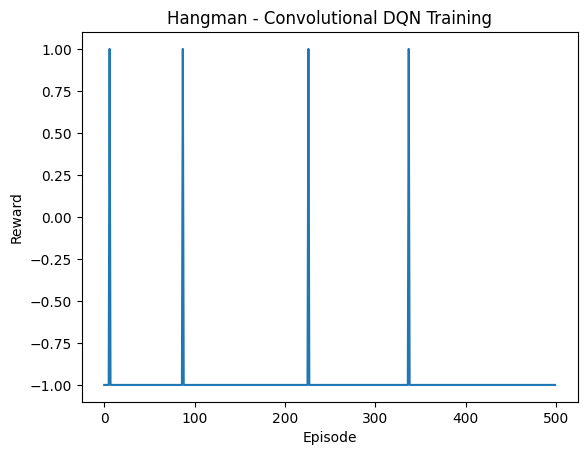


Training Complete:
Episodes: 500
Average reward: -0.98
Max reward: 1.00
Wins: 4

RECORDING DEMONSTRATION VIDEOS
Recording episode 0...


Episode 0: Reward = -1.0, Steps = 167


----------------------------------------
Recording episode 100...


Episode 100: Reward = -1.0, Steps = 178


----------------------------------------
Recording episode 200...


Episode 200: Reward = -1.0, Steps = 161


----------------------------------------
Recording episode 300...


Episode 300: Reward = -1.0, Steps = 160


----------------------------------------
Recording episode 400...


Episode 400: Reward = -1.0, Steps = 155


----------------------------------------
Recording episode 500...


Episode 500: Reward = 1.0, Steps = 186


----------------------------------------
All demonstration videos recorded!


In [9]:
if __name__ == "__main__":
    # Quick environment verification
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    state, _ = env.reset()
    print(f"State shape: {state.shape}, Action space: {env.action_space.n}")
    env.close()

    # Start training
    print("Starting Convolutional DQN training...")
    q_net, rewards_all = train_dqn(episodes=500)

    # Training statistics
    plt.plot(rewards_all)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Hangman - Convolutional DQN Training")
    plt.show()

    print(f"\nTraining Complete:")
    print(f"Episodes: {len(rewards_all)}")
    print(f"Average reward: {np.mean(rewards_all):.2f}")
    print(f"Max reward: {np.max(rewards_all):.2f}")
    print(f"Wins: {sum(1 for r in rewards_all if r > 0)}")

    # Record demonstration videos
    print("\n" + "="*50)
    print("RECORDING DEMONSTRATION VIDEOS")
    print("="*50)

    record_env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")

    for ep_num in [0, 100, 200, 300, 400, 500]:
        print(f"Recording episode {ep_num}...")
        video_file, final_reward, steps = record_episode(record_env, q_net, preprocess_state, ep_num)
        print(f"Episode {ep_num}: Reward = {final_reward}, Steps = {steps}")
        display(show_video(video_file))
        print("-" * 40)

    record_env.close()
    print("All demonstration videos recorded!")